In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import time

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [10]:
class VariationalAutoencoder(object):
    def __init__(self, name,
                 n_inputs=784,
                 n_neurons_encoder = [2048, 256],
                 n_latent=2,
                 n_neurons_decoder = [256, 2048],
                 batch_size = 128,
                 activation = tf.nn.tanh):
        
        tf.reset_default_graph()
        
        self.name = name
        
        # ATTRIBUTES
        self.N = n_inputs
        self.n_encoder = n_neurons_encoder
        self.n_decoder = n_neurons_decoder
        self.n_latent = n_latent
        self.length_encoder = len(n_neurons_encoder)
        self.length_decoder = len(n_neurons_decoder)
        self.layers = self.length_encoder + self.length_decoder + 1 
        self.activ = activation
        
        ## DATA PLACEHOLDERS (BATCHES)
        with tf.name_scope('input'):
            self.X = tf.placeholder(tf.float32, shape=[None, self.N], name='X')
            
        with tf.name_scope('input_reshape'):
            image_shaped_input = tf.reshape(self.X, [-1, 28, 28, 1])
            tf.summary.image('input', image_shaped_input, 10)
        
        # INITIALIZE WEIGHTS & BIASES
        self.W_enc, self.W_z_mu, self.W_z_log_sigma, self.W_dec = self.initialize_W()
        self.b_enc, self.b_z_mu, self.b_z_log_sigma, self.b_dec = self.initialize_b()
            
        ## COMPUTATIONAL GRAPH
        self.Y, self.z_mu, self.z_log_sigma, _ = self.feedforward()
        self.loss, self.kl, self.ell = self.get_nelbo()

        ## Initialize the session
        self.session = tf.InteractiveSession()
    
        print("VAE "+self.name)
        self.print_network_size()
        
        
    def print_network_size(self):
        """Print the sizes of biases and weights"""
        print(" --> Encoder")        
        for w, b in zip(self.W_enc, self.b_enc):
            print(w.get_shape(), b.get_shape())
            
        print(" --> Latent Space")   
        print(self.W_z_mu.get_shape(), self.b_z_mu.get_shape())
        print(self.W_z_log_sigma.get_shape(), self.b_z_log_sigma.get_shape())
        
        print(" --> Decoder")   
        for w, b in zip(self.W_dec, self.b_dec):
            print(w.get_shape(), b.get_shape())

    ## ---------------------------------------------------------------------            
    ## --------------- TF WEIGHTS & BIASES INITIALIZATION ------------------
    ## ---------------------------------------------------------------------
    
    def initialize_W(self):
        """
        Define all the weights for the network.
        We initialize them to standard normal iid using Xavier Initializer
        """
        
        W_encoder = []
        W_latent_mu = []
        W_latent_log_sigma = []
        W_decoder = []
        
        with tf.name_scope("Encoder_layer_weights"):
            W_encoder.append(w_xavier(shape=[self.N, self.n_encoder[0]]))
            for i in range(1, self.length_encoder):
                W_encoder.append(w_xavier(shape=[self.n_encoder[i-1], self.n_encoder[i]]))
        
        with tf.name_scope("Latent_layer_weights"):
            W_latent_mu = w_xavier(shape =[self.n_encoder[-1], self.n_latent]) 
            W_latent_log_sigma = w_xavier(shape =[self.n_encoder[-1], self.n_latent])      
            
        with tf.name_scope("Decoder_layer_weights"):
            W_decoder.append(w_xavier(shape=[self.n_latent, self.n_decoder[0]]))
            for i in range(1, self.length_decoder):
                W_decoder.append(w_xavier(shape=[self.n_decoder[i-1], self.n_decoder[i]]))
            W_decoder.append(w_xavier(shape=[self.n_decoder[-1], self.N]))
        
        return W_encoder, W_latent_mu, W_latent_log_sigma, W_decoder

    
    def initialize_b(self):
        """
        Define all the biases for the network.
        We initialize them to standard normal iid using Xavier Initializer
        """
        
        b_encoder = []
        b_latent_mu = []
        b_latent_log_sigma = []
        b_decoder = []
        
        with tf.name_scope("Encoder_layer_biases"):
            b_encoder.append(b_xavier(shape=[self.n_encoder[0]]))
            for i in range(1, self.length_encoder):
                b_encoder.append(b_xavier(shape=[self.n_encoder[i]]))
        
        with tf.name_scope("Latent_layer_biases"):
            b_latent_mu = b_xavier(shape =[self.n_latent]) 
            b_latent_log_sigma = b_xavier(shape =[self.n_latent])      
            
        with tf.name_scope("Decoder_layer_biases"):
            b_decoder.append(b_xavier(shape=[self.n_decoder[0]]))
            for i in range(1, self.length_decoder):
                b_decoder.append(b_xavier(shape=[self.n_decoder[i]]))
            b_decoder.append(b_xavier(shape=[self.N]))
            
        return b_encoder, b_latent_mu, b_latent_log_sigma, b_decoder

    
    ## ---------------------------------------------------------------------            
    ## ----------------- SAMPLING FROM THE LATENT SPACE --------------------
    ## ---------------------------------------------------------------------
    
    def get_samples(self, d_in, d_out):
        """
        Sample from noise distribution p(eps) ~ N(0, 1)
        a matrix of samples of dimension [d_in, d_out].
        """
        return tf.random_normal(shape=[d_in, d_out])

    def sample_from_Z(self, z_mu, z_log_o):
        """
        Samples from the posterior of the variational latent space.
        We draw samples using the reparameterization trick.
        """
        return z_mu + tf.exp(z_log_o) * self.get_samples(tf.shape(self.X)[0], self.n_latent)
    
        
        
    ## ---------------------------------------------------------------------            
    ## --------------------------- FEEDFORWARD -----------------------------
    ## ---------------------------------------------------------------------
    def encoder(self, net):
        '''ENCODER: transform the input image into the latent space'''
        for i in range(self.length_encoder):
            net = self.activ(tf.matmul(net, self.W_enc[i]) + self.b_enc[i])
            
        z_mu = tf.matmul(net, self.W_z_mu) + self.b_z_mu
        z_log_sigma = 0.5 * (tf.matmul(net, self.W_z_log_sigma) + self.b_z_log_sigma)
        
        return z_mu, z_log_sigma
        
        
    def decoder(self, z):
        '''DECODER: transform a Latent Space representation into an image'''
        net = self.activ(tf.matmul(z, self.W_dec[0]) + self.b_dec[0])
        for i in range(1, self.length_decoder):
            net = self.activ(tf.matmul(net, self.W_dec[i]) + self.b_dec[i])
        
        return tf.nn.sigmoid(tf.matmul(net, self.W_dec[-1]) + self.b_dec[-1])        
                
    
    def feedforward(self):
        """
        Feedforward pass excluding last layer's transfer function.
        intermediate : index of intermediate layer for output generation
        """
        net = self.X

        # ENCODER
        z_mu, z_log_sigma = self.encoder(net)

        # LATENT: Sample from posterior
        z = self.sample_from_Z(z_mu, z_log_sigma)

        # DECODER
        Y = self.decoder(z)        
                
        return Y, z_mu, z_log_sigma, z
    
    
    ## ---------------------------------------------------------------------            
    ## ------------------- LOSS: EXPECTED LOWER BOUND ----------------------
    ## ---------------------------------------------------------------------    
    
    def get_ell(self):
        """
        Returns the expected log-likelihood of the lower bound.
        For this we use a bernouilli LL.
        """
        target = self.X
        output = self.Y
        # p(x|z)        
        return - tf.reduce_sum((  target  ) * tf.log(output + 1e-10) +
                               (1 - target) * tf.log(1 - output + 1e-10), 1)

    
    def get_kl(self):
        """
        d_kl(q(z|x)||p(z)) returns the KL-divergence between the prior p and the variational posterior q.
        :return: KL divergence between q and p
        """   
        # Formula: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return - 0.5 * tf.reduce_sum( 1.0 + 2.0 * self.z_log_sigma - tf.square(self.z_mu) -
                                   tf.exp(2.0 * self.z_log_sigma), 1)
        
        
    def get_nelbo(self):
        """ Returns the negative ELBOW, which allows us to minimize instead of maximize. """
        kl = tf.reduce_mean(self.get_kl())
        ell = tf.reduce_mean(self.get_ell())
        nelbo = kl + ell
        return nelbo, kl, ell
    
    
    ## ---------------------------------------------------------------------            
    ## --------------------------- LEARNING --------------------------------
    ## ---------------------------------------------------------------------  
    
    def learn(self, learning_rate=0.001, batch_size=128,
                    epochs=100, display_step=1):
        """ Our learning procedure """
        optimizer = tf.train.AdamOptimizer(learning_rate)

        ## Set all_variables to contain the complete set of TF variables to optimize
        all_variables = tf.trainable_variables()

        ## Define the optimizer
        train_step = optimizer.minimize(self.loss, var_list=all_variables)

        tf.summary.scalar('negative_elbo', self.loss)
        #tf.summary.scalar('kl_div', self.kl)
        #tf.summary.scalar('ell', self.ell)
        
        merged = tf.summary.merge_all()
        
        train_writer = tf.summary.FileWriter('logs/train', self.session.graph)
        test_writer = tf.summary.FileWriter('logs/test')        
        
        ## Initialize all variables
        self.session.run(tf.global_variables_initializer())
        
        # Initial model print
        print("*MODEL [", self.name,"] {l_r: %.4f; n_iter: %d; batch: %d}"%\
              (learning_rate, epochs, batch_size))
        print (" -> START Training!")
        
        t = time.time()
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for epoch in range(epochs):
            train_cost = 0.
            batch_ell = 0.
            batch_kl = 0.
            for batch_i in range(total_batch):
                batch_xs, _ = mnist.train.next_batch(batch_size)

                _, loss, ell, kl, summary = self.session.run(
                    [train_step, self.loss, self.ell, self.kl, merged],
                                    feed_dict={self.X: batch_xs})
                
                train_writer.add_summary(summary, epoch * total_batch + batch_i)
                train_cost += loss / total_batch
                batch_ell += ell / total_batch
                batch_kl += kl / total_batch
                
            print("   [%.1f] Epoch: %02d | NELBO: %.6f | ELL: %.6f | KL: %.6f"%(
                time.time()-t,epoch, train_cost, batch_ell, batch_kl ))
        
        print (" -> Training FINISHED in %.1f seconds."%(time.time()-t))
        self.serialize('FOLDS/')
        train_writer.close()
        test_writer.close()
        
    def benchmark(self, validation=False, batch_size = 128):
        # TEST LOG LIKELIHOOD
        if validation:
            benchmark_data = mnist.validation
            title = 'Validation LogLikelihood:'
        else:
            benchmark_data = mnist.test
            title = 'Test LogLikelihood:'
        
        total_batch = benchmark_data.num_examples // batch_size
        ell = 0
        for batch_i in range(total_batch):
            batch_xs, _ = benchmark_data.next_batch(batch_size)
            c = self.session.run(self.ell,
                   feed_dict={self.X: batch_xs, self.Y: batch_xs})
            ell+= c/total_batch
        print("Model ", self.name, ". ", title, ell)
        
        # RECONSTRUCTION VISUALIZATION
        f = plot_recon()
        f.savefig(self.name+'_recon.png' % t_i)
        
        # LATENT SPACE VISUALIZATION
        f = plot_recon()
        f.savefig(self.name+'_recon.png' % t_i)
        
        return ell
        
    def serialize(self, path):
        '''Save the model in a file'''
        
        saver = tf.train.Saver()
        save_path = saver.save(self.session, path+self.name)
        print("Model saved in file: %s" % path+self.name)
        
        
    def restore(self, path):
        '''Restore the saved model'''
        
        saver = tf.train.Saver()   
        sess = tf.InteractiveSession()
        saver.restore(sess, save_path=path)
        self.session = sess
        print("Model restored from file: %s" % path)
    
    def encode(self, input_vector):
        '''Encode the input into the Latent Space'''
        
        _, _, _, z = self.session.run(self.feedforward,
                                feed_dict={self.X: input_vector})
        return z
    
    def decode(self, z):
        '''Decode from the latent space into the out'''
        
        _, z_m, z_log_o = self.session.run(self.decode,
                                feed_dict={self.X: input_vector})
        return z_m, z_log_o
    
    
    def plot_recon(self, n_examples=20):
        '''Visualize Example Reconstrutions for the model'''
        
        xs = mnist.test.next_batch(n_examples)
        recon = self.session.run(self.Y, feed_dict={self.X: xs})
        fig, axs = plt.subplots(2, n_examples, figsize=(20, 4))
        for i in range(n_examples):
            axs[0][i].imshow(np.reshape(xs[i, :], (28, 28)), cmap='gray')
            axs[1][i].imshow(np.reshape(recon[i, ...], (28, 28)), cmap='gray')
            axs[0][i].axis('off')
            axs[1][i].axis('off')
        plt.show()
        return fig
    
    
    def plot_latent_recon(self, n_examples=20):        
        '''Visualize Reconstructions from the latent space'''
        
        imgs = []
        for img_i in np.linspace(-3, 3, n_examples):
            for img_j in np.linspace(-3, 3, n_examples):
                z = np.array([[img_i, img_j]], dtype=np.float32)
                recon = self.session.run(self.Y, feed_dict={self.X: xs})
                imgs.append(np.reshape(recon, (1, 28, 28, 1)))
        imgs_cat = np.concatenate(imgs)
        ax_manifold.imshow(montage_batch(imgs_cat))
        fig_manifold.savefig('manifold_%08d.png' % t_i)

In [4]:
# %%
def w_xavier(shape):
    initial = tf.random_normal(shape, mean=0.0,
                               stddev=tf.sqrt(3./sum(shape)))
    return tf.Variable(initial)


# %%
def b_xavier(shape):
    initial = tf.random_normal(shape, mean=0.0,
                               stddev=tf.sqrt(3./sum(shape)))
    return tf.Variable(initial)

In [9]:
VA =  VariationalAutoencoder('VA_1',
                 n_inputs=784,
                 n_neurons_encoder = [256, 128],
                 n_latent=2,
                 n_neurons_decoder = [128, 256],
                 batch_size = 128)

VAE VA_1
 --> Encoder
(784, 256) (256,)
(256, 128) (128,)
 --> Latent Space
(128, 2) (2,)
(128, 2) (2,)
 --> Decoder
(2, 128) (128,)
(128, 256) (256,)
(256, 784) (784,)


In [54]:
VA.learn(epochs=100)

*MODEL [ VA_1 ] {l_r: 0.0010; n_iter: 30; batch: 128}
 -> START Training!
   [2.4] Epoch: 00 | NELBO: 194.150667 | ELL: -189.690730 | KL: 4.459936
   [4.7] Epoch: 01 | NELBO: 167.858819 | ELL: -163.311105 | KL: 4.547714
   [7.0] Epoch: 02 | NELBO: 161.223519 | ELL: -156.251087 | KL: 4.972433
   [9.4] Epoch: 03 | NELBO: 157.020086 | ELL: -151.743727 | KL: 5.276359
   [11.8] Epoch: 04 | NELBO: 153.735214 | ELL: -148.216445 | KL: 5.518769
   [14.3] Epoch: 05 | NELBO: 151.586451 | ELL: -145.878668 | KL: 5.707784
   [16.6] Epoch: 06 | NELBO: 149.691282 | ELL: -143.860337 | KL: 5.830945
   [19.0] Epoch: 07 | NELBO: 148.412912 | ELL: -142.473502 | KL: 5.939410
   [21.4] Epoch: 08 | NELBO: 147.353133 | ELL: -141.333383 | KL: 6.019750
   [23.8] Epoch: 09 | NELBO: 146.704975 | ELL: -140.611974 | KL: 6.093001
   [26.2] Epoch: 10 | NELBO: 145.803629 | ELL: -139.648479 | KL: 6.155149
   [28.5] Epoch: 11 | NELBO: 145.221939 | ELL: -139.017170 | KL: 6.204769
   [30.8] Epoch: 12 | NELBO: 144.585770 | 

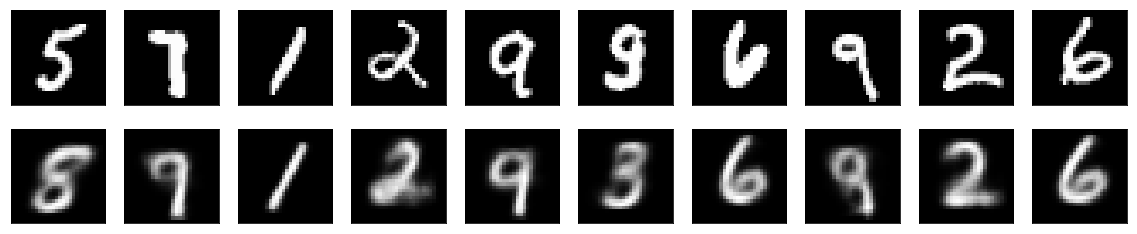

In [39]:
VA.plot_enc_dec()

In [4]:
# %%
def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)


# %%
def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

In [7]:

# %%
def test_mnist():
    """Summary
    Returns
    -------
    name : TYPE
        Description
    """
    # %%


    # %%
    # load MNIST as before
    ae = VAE()

    # %%
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

    # %%
    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # %%
    # Fit all training data
    t_i = 0
    batch_size = 100
    n_epochs = 50
    n_examples = 20
    test_xs, _ = mnist.test.next_batch(n_examples)
    xs, ys = mnist.test.images, mnist.test.labels
    fig_manifold, ax_manifold = plt.subplots(1, 1)
    fig_reconstruction, axs_reconstruction = plt.subplots(2, n_examples, figsize=(10, 2))
    fig_image_manifold, ax_image_manifold = plt.subplots(1, 1)
    for epoch_i in range(n_epochs):
        print('--- Epoch', epoch_i)
        train_cost = 0
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            train_cost += sess.run([ae['cost'], optimizer],
                                   feed_dict={ae['x']: batch_xs})[0]
            if batch_i == 1:
                # %%
                # Plot example reconstructions from latent layer
                imgs = []
                for img_i in np.linspace(-3, 3, n_examples):
                    for img_j in np.linspace(-3, 3, n_examples):
                        z = np.array([[img_i, img_j]], dtype=np.float32)
                        recon = sess.run(ae['y'], feed_dict={ae['z']: z})
                        imgs.append(np.reshape(recon, (1, 28, 28, 1)))
                imgs_cat = np.concatenate(imgs)
                ax_manifold.imshow(montage_batch(imgs_cat))
                fig_manifold.savefig('manifold_%08d.png' % t_i)

                # %%
                # Plot example reconstructions
                recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
                print(recon.shape)
                for example_i in range(n_examples):
                    axs_reconstruction[0][example_i].imshow(
                        np.reshape(test_xs[example_i, :], (28, 28)),
                        cmap='gray')
                    axs_reconstruction[1][example_i].imshow(
                        np.reshape(
                            np.reshape(recon[example_i, ...], (784,)),
                            (28, 28)),
                        cmap='gray')
                    axs_reconstruction[0][example_i].axis('off')
                    axs_reconstruction[1][example_i].axis('off')
                fig_reconstruction.savefig('reconstruction_%08d.png' % t_i)

                # %%
                # Plot manifold of latent layer
                zs = sess.run(ae['z'], feed_dict={ae['x']: xs})
                ax_image_manifold.clear()
                ax_image_manifold.scatter(zs[:, 0], zs[:, 1],
                    c=np.argmax(ys, 1), alpha=0.2)
                ax_image_manifold.set_xlim([-6, 6])
                ax_image_manifold.set_ylim([-6, 6])
                ax_image_manifold.axis('off')
                fig_image_manifold.savefig('image_manifold_%08d.png' % t_i)

                t_i += 1


        print('Train cost:', train_cost /
              (mnist.train.num_examples // batch_size))

        valid_cost = 0
        for batch_i in range(mnist.validation.num_examples // batch_size):
            batch_xs, _ = mnist.validation.next_batch(batch_size)
            valid_cost += sess.run([ae['cost']],
                                   feed_dict={ae['x']: batch_xs})[0]
        print('Validation cost:', valid_cost /
              (mnist.validation.num_examples // batch_size))